In [70]:
from pynwb import NWBHDF5IO
from pathlib import Path
import numpy as np
import mne
from pipeline.utils import make_mne_epochs, make_epochs_tfr
import matplotlib.pylab as plt

In [ ]:
sbj, session = 4, 3

fname = "sub-{0:>02d}_ses-{1:.0f}_behavior+ecephys.nwb".format(sbj, session)

io = NWBHDF5IO(Path('../data', fname), mode='r', load_namespaces=True)

nwb = io.read()

In [13]:
neural_data = nwb.acquisition['ElectricalSeries'].data

print("Neural data shape: ", neural_data.shape)
n_times, n_chan = neural_data.shape
SF = nwb.acquisition['ElectricalSeries'].rate
print("Sampling rate: ", SF)

info = mne.create_info(n_chan, ch_types='ecog', sfreq=SF)


mne_data_chunk = mne.io.RawArray(neural_data[:].reshape(n_chan, -1), info)

Neural data shape:  (28175839, 84)
Sampling rate:  500.0
Creating RawArray with float64 data, n_channels=84, n_times=28175839
    Range : 0 ... 28175838 =      0.000 ... 56351.676 secs
Ready.


In [14]:
trials = np.array(nwb.intervals['reaches']['start_time'].data) * SF
trials = trials[(trials > SF * 2) & (trials < neural_data.shape[0] - SF * 2)]
print("N trials: ", len(trials))

N trials:  13


In [15]:
epochs = make_mne_epochs(mne_data_chunk, trials, -0.5, 1.5)
epochs.info

Not setting metadata
13 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 13 events and 1001 original time points ...
0 bad epochs dropped


<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 84 ECoG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 84
 projs: []
 sfreq: 500.0 Hz
>

In [37]:
epochs.get_data().shape

(13, 84, 1001)

In [57]:
evoked = epochs.average()
evoked

<Evoked | '1' (average, N=13), -0.5 – 1.5 sec, baseline -0.5 – 0 sec, 84 ch, ~740 kB>

In [171]:
evoked.data[np.isfinite(evoked.data) == False] = 0

In [172]:
np.isfinite(evoked.data).all()

True

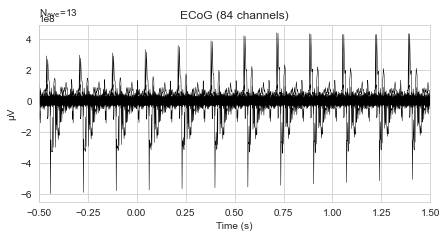

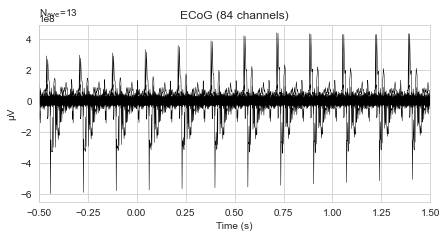

In [173]:
evoked.plot()

In [16]:
epochs_tfr = make_epochs_tfr(epochs)
epochs_tfr.info

Not setting metadata


<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 84 ECoG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 84
 projs: []
 sfreq: 500.0 Hz
>

In [20]:
epochs_tfr.data.shape

(13, 84, 8, 1001)

In [118]:
mne.time_frequency.stft(evoked.data[0, :], wsize=8).shape

Number of frequencies: 5
Number of time steps: 251


(1, 5, 251)

Number of frequencies: 9
Number of time steps: 126


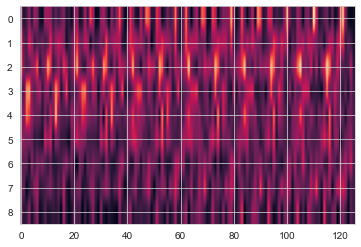

In [129]:
ch_num = 25
plt.imshow(np.abs(mne.time_frequency.stft(evoked.data[ch_num, :], wsize=16).squeeze()), aspect='auto')

In [140]:
epochs_tfr = make_epochs_tfr(epochs, np.logspace(*np.log10([10, 100]), num=100), n_cycles=10)

Not setting metadata


Applying baseline correction (mode: logratio)


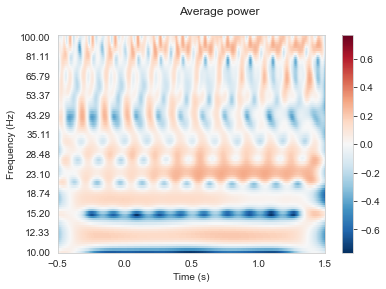

[<Figure size 432x288 with 2 Axes>]

In [151]:
avgpower = epochs_tfr.average(dim = 'epochs')
avgpower.plot(picks=[13], title="Average power",
              baseline=(-0.5, -0.3), mode='logratio') # , yscale='log'

Applying baseline correction (mode: logratio)


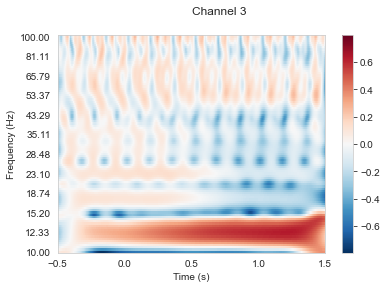

[<Figure size 432x288 with 2 Axes>]

In [155]:
avgpower.plot(picks=[3], title="Channel 3",
              baseline=(-0.5, -0.3), mode='logratio')

Need more than one channel to make topography for ecog. Disabling interactivity.


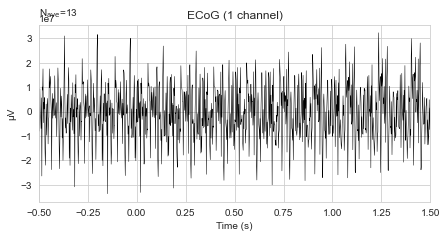

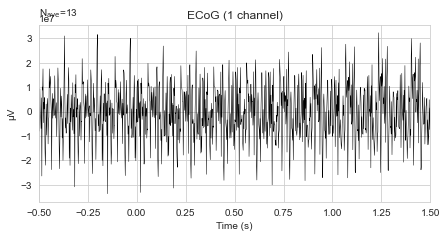

In [178]:
evoked.plot(picks=[3])

Applying baseline correction (mode: logratio)


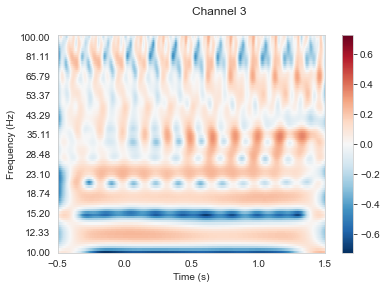

[<Figure size 432x288 with 2 Axes>]

In [162]:
avgpower.plot(picks=[8], title="Channel 3",
              baseline=(-0.5, -0.3), mode='logratio')

In [58]:
np.logspace(*np.log10([6, 35]), num=8)

array([ 6.        ,  7.71912254,  9.93080879, 12.77618833, 16.43682721,
       21.1463139 , 27.2051647 , 35.        ])

In [115]:
freqs = np.logspace(*np.log10([8, 120]), num=100)
# freqs = np.linspace(8, 120, 100)
n_cycles = 10.  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3)

Applying baseline correction (mode: logratio)


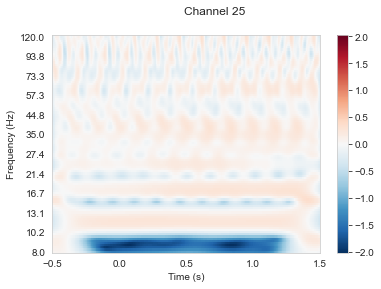

[<Figure size 432x288 with 2 Axes>]

In [116]:
ch_num = 25
power.plot([ch_num], baseline=(-0.5, -0.3), mode='logratio', title=f"Channel {power.ch_names[ch_num]}")